# OpenAI Responses API: Complete Tutorial

## Overview

The OpenAI Responses API is a superset of Chat Completions, meaning everything you can do with Chat Completions can be done with the Responses API, plus additional features. This unified interface simplifies building AI applications with built-in tools, conversation management, and enhanced capabilities.

### Key Features
- **Simplified Interface**: Single API for complex interactions
- **Built-in Tools**: Web search, file search, computer use
- **Stateful Conversations**: Automatic conversation management
- **Structured Outputs**: Type-safe responses with Pydantic
- **Enhanced Function Calling**: Custom tool integration

## Setup

In [ ]:
# Uncomment to install required packages
# !pip install openai python-dotenv

In [2]:
import os
from openai import OpenAI
from dotenv import load_dotenv
import json

# Load environment variables
load_dotenv()

# Initialize client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## 1. Basic Text Generation

In [3]:
# Simple text generation
response = client.responses.create(
    model="gpt-4o",
    input="Write a haiku about artificial intelligence."
)

print(response.output_text)

Metal minds awake,  
Silent code weaving through thoughts—  
Dreams of electric.


### Instructions vs Input

In [4]:
# Using instructions for system-level guidance
response = client.responses.create(
    model="gpt-4o",
    instructions="You are a helpful coding assistant. Always provide working code examples.",
    input="How do I read a CSV file in Python?"
)

print(response.output_text)

To read a CSV file in Python, you can use the `csv` module or the `pandas` library. Here are examples using both methods:

### Using the `csv` Module

```python
import csv

# Open the CSV file
with open('filename.csv', mode='r') as file:
    csv_reader = csv.reader(file)
    
    # Read each row
    for row in csv_reader:
        print(row)
```

### Using the `pandas` Library

First, ensure you have pandas installed. You can install it via pip:

```bash
pip install pandas
```

Then use the following code to read a CSV file:

```python
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('filename.csv')

# Display the DataFrame
print(df)
```

Both methods will allow you to read and process CSV files, but `pandas` provides more powerful data manipulation capabilities and is generally preferred for data analysis tasks.


## 2. Conversation State Management

### Manual State Management

In [5]:
# Build conversation manually
conversation = [
    {"role": "user", "content": "What's the capital of France?"},
    {"role": "assistant", "content": "The capital of France is Paris."},
    {"role": "user", "content": "What's the population?"}
]

response = client.responses.create(
    model="gpt-4o-mini",
    input=conversation
)

print(response.output_text)

As of my last update, the population of Paris is approximately 2.1 million within the city proper. If you include the metropolitan area, the population is roughly around 12 million. However, for the most current figures, it's best to check the latest statistics.


### Automatic State Management

In [6]:
# Let OpenAI handle conversation state
response1 = client.responses.create(
    model="gpt-4o-mini",
    input="Tell me about Python programming."
)

# Continue conversation using previous response ID
response2 = client.responses.create(
    model="gpt-4o-mini",
    previous_response_id=response1.id,
    input="What are its main advantages?"
)

print("First response:", response1.output_text)
print("\nSecond response:", response2.output_text)

First response: Python is a high-level, interpreted programming language known for its readability, simplicity, and versatility. Developed in the late 1980s by Guido van Rossum and first released in 1991, Python emphasizes code clarity and programmer productivity.

### Key Features

1. **Syntax**: Python's syntax is clean and easy to understand, making it accessible for beginners. It uses indentation to define code blocks instead of braces or keywords.

2. **Interpreted Language**: Python is executed line by line, which is helpful for debugging and testing code interactively.

3. **Dynamically Typed**: You don't need to declare variable types, as Python infers them at runtime.

4. **Extensive Libraries**: Python has a rich ecosystem of libraries and frameworks, such as:
   - **NumPy** and **Pandas** for data manipulation.
   - **Matplotlib** and **Seaborn** for data visualization.
   - **Django** and **Flask** for web development.
   - **TensorFlow** and **PyTorch** for machine learnin

## 3. Function Calling

Simple demo of OpenAI function calling - AI decides when to call your custom functions.

**How it works:**
1. Define a Python function  
2. Describe it to OpenAI with a tool schema  
3. AI automatically calls it when needed  
4. You execute the function and see the result

In [3]:
import requests

def get_weather(city):
    """Get weather using a simple API"""
    try:
        # Simple weather API that returns JSON
        url = f"https://wttr.in/{city}?format=j1"
        data = requests.get(url, timeout=5).json()
        temp = data["current_condition"][0]["temp_C"]
        desc = data["current_condition"][0]["weatherDesc"][0]["value"]
        return f"🌤️ {city}: {temp}°C, {desc}"
    except:
        return f"🌤️ {city}: 22°C, Sunny (demo data)"

# Define the tool for OpenAI
tools = [{
    "type": "function",
    "name": "get_weather",
    "description": "Get weather for a city",
    "parameters": {
        "type": "object",
        "properties": {"city": {"type": "string"}},
        "required": ["city"]
    }
}]

# Call OpenAI with the tool
response = client.responses.create(
    model="gpt-4o-mini",
    input="What's the weather in Tokyo?",
    tools=tools
)

# Execute any function calls
for output in response.output:
    if hasattr(output, 'type') and output.type == 'function_call':
        print(f"🤖 AI called: {output.name}({output.arguments})")
        
        # Execute the function
        import json
        args = json.loads(output.arguments)
        result = get_weather(**args)
        
        print(f"📊 Result: {result}")
        print("✅ Function calling works!")
        break

🤖 AI called: get_weather({"city":"Tokyo"})
📊 Result: 🌤️ Tokyo: 31°C, Partly cloudy
✅ Function calling works!
📊 Result: 🌤️ Tokyo: 31°C, Partly cloudy
✅ Function calling works!


## 4. Structured Outputs

In [ ]:
from pydantic import BaseModel
from typing import List

# Define response structure
class EventDetails(BaseModel):
    name: str
    date: str
    participants: List[str]
    location: str

# Get the schema and add required additionalProperties field
schema = EventDetails.model_json_schema()
schema["additionalProperties"] = False

# Generate structured output
response = client.responses.create(
    model="gpt-4o",
    input="Alice and Bob are meeting for a coding workshop at the library on Friday.",
    # Define the output text format
    text={
        "format": {
            "type": "json_schema",
            "name": "event_extraction",
            "schema": schema,
            "strict": True
        }
    }
)

# Parse structured response
event_data = json.loads(response.output_text)
print(json.dumps(event_data, indent=2))

{
  "name": "Coding Workshop",
  "date": "Friday",
  "participants": [
    "Alice",
    "Bob"
  ],
  "location": "Library"
}


## 5. Built-in Tools

### Web Search

In [26]:
# Use web search tool
response = client.responses.create(
    model="gpt-4o",
    input="What are the latest developments in AI in 2025?",
    tools=[{"type": "web_search_preview"}]
)

print(response.output_text)

# Access citations
for output in response.output:
    if hasattr(output, 'content'):
        for content in output.content:
            if hasattr(content, 'annotations'):
                for annotation in content.annotations:
                    if annotation.type == 'url_citation':
                        print(f"Source: {annotation.title}")
                        print(f"URL: {annotation.url}")

As of August 2025, artificial intelligence (AI) continues to evolve rapidly, influencing various sectors and prompting significant regulatory and ethical considerations. Key developments include:

**Regulatory Initiatives and Global Cooperation**

- **U.S. SEC's AI Task Force**: On August 1, 2025, the U.S. Securities and Exchange Commission (SEC) established an AI task force to enhance innovation and efficiency within its operations. Valerie Szczepanik was appointed as the SEC's first Chief AI Officer to lead this initiative. ([reuters.com](https://www.reuters.com/technology/us-securities-regulator-announces-ai-task-force-2025-08-01/?utm_source=openai))

- **China's Proposal for Global AI Cooperation**: At the World Artificial Intelligence Conference in Shanghai on July 26, 2025, Chinese Premier Li Qiang proposed creating an international organization to coordinate AI development and governance. This initiative aims to prevent monopolization by a few powerful entities and promote equit

### File Search

In [ ]:
# Upload and search files (requires vector store setup)
# First, upload a file with correct path
file_path = "a-practical-guide-to-building-agents.pdf"
with open(file_path, "rb") as file:
    uploaded_file = client.files.create(file=file, purpose="assistants")

print(f"File uploaded: {uploaded_file.id}")

# Create vector store
vector_store = client.vector_stores.create(name="knowledge_base")
print(f"Vector store created: {vector_store.id}")

# Add file to vector store
file_batch = client.vector_stores.files.create(
    vector_store_id=vector_store.id,
    file_id=uploaded_file.id
)

print(f"File added to vector store. Status: {file_batch.status}")

# Wait a moment for processing (in production, you'd check the status)
import time
time.sleep(5)  # Wait a bit longer for processing

# Check if the file is processed
file_status = client.vector_stores.files.retrieve(
    vector_store_id=vector_store.id,
    file_id=uploaded_file.id
)
print(f"File processing status: {file_status.status}")

# Search within uploaded files using correct tool structure
response = client.responses.create(
    model="gpt-4o",
    input="What are AI Agents based on the uploaded document? Provide a detailed explanation of their key characteristics and capabilities.",
    tools=[{
        "type": "file_search",
        "vector_store_ids": [vector_store.id],
        "max_num_results": 5
    }]
)

print("Response:")
print(response.output_text)

# Also show any citations if available
for output in response.output:
    if hasattr(output, 'content'):
        for content_item in output.content:
            if hasattr(content_item, 'annotations'):
                for annotation in content_item.annotations:
                    if hasattr(annotation, 'file_citation'):
                        print(f"\nSource: File {annotation.file_citation.file_id}")
                        print(f"Quote: {annotation.file_citation.quote}")

File uploaded: file-9RjS9RgNbcUu2VExQf5XnF
Vector store created: vs_688d979adc4c81919c04bdf5834e452a
Vector store created: vs_688d979adc4c81919c04bdf5834e452a
File added to vector store. Status: in_progress
File added to vector store. Status: in_progress
File processing status: completed
File processing status: completed
Response:
AI Agents, as described in the document, are LLM-powered systems capable of independently accomplishing tasks on behalf of users. Here's a detailed explanation of their key characteristics and capabilities:

### Key Characteristics:

1. **Independence:** 
   - AI Agents perform tasks with a high degree of independence, streamlining and automating workflows without constant user intervention.

2. **LLM Integration:** 
   - They leverage large language models (LLMs) to manage workflow execution and make decisions. This includes recognizing when a workflow is complete and correcting actions if needed.

3. **Tool Use:**
   - Agents have access to various tools to

## 6. Image Analysis

Image being analyzed:


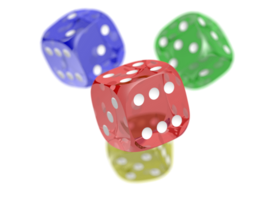


AI Analysis:
The image depicts four colorful dice. They are shown in red, blue, green, and yellow, each with white dots representing numbers. The dice appear to be floating or rolling in mid-air.
The image depicts four colorful dice. They are shown in red, blue, green, and yellow, each with white dots representing numbers. The dice appear to be floating or rolling in mid-air.


In [ ]:
# Analyze images
from IPython.display import Image, display
import requests
from io import BytesIO

# Image URL to analyze
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/PNG_transparency_demonstration_1.png/280px-PNG_transparency_demonstration_1.png"

# Display the image first
print("Image being analyzed:")
try:
    # Download and display the image
    response_img = requests.get(image_url)
    img = Image(data=response_img.content)
    display(img)
except:
    print(f"Could not display image from: {image_url}")

print("\n" + "="*50)
print("AI Analysis:")
print("="*50)

# Analyze the image with OpenAI
response = client.responses.create(
    model="gpt-4o",
    input=[
        {"role": "user", "content": "Describe what you see in this image."},
        {
            "role": "user", 
            "content": [{
                "type": "input_image",
                "image_url": image_url
            }]
        }
    ]
)

print(response.output_text)

## 7. Streaming Responses

In [4]:
# Stream responses in real-time
stream = client.responses.create(
    model="gpt-4o-mini",
    input="Explain machine learning in simple terms.",
    stream=True
)

print("Streaming response:")
for event in stream:
    if hasattr(event, "type") and "text.delta" in event.type:
        print(event.delta, end="", flush=True)

Streaming response:
SureSure! Machine! Machine learning is learning is a way a way for for computers to learn computers to learn from data from data without being without being explicitly programmed explicitly programmed for every task.

 for every task.

Think ofThink of it like it like teaching a teaching a child. child. Instead of Instead of giving them giving them a step a step-by-step-by-step guide on guide on how to how to recognize a recognize a dog, dog, you show you show them lots them lots of pictures of pictures of dogs of dogs. Over. Over time, time, they learn they learn to identify to identify a dog a dog on their on their own based own based on what on what they’ve they’ve seen. seen. 

In 

In the same way, the same way, machine learning machine learning uses data uses data to help to help computers recognize computers recognize patterns, patterns, make decisions make decisions, or, or predict outcomes predict outcomes. 

. 

There areThere are different types different

## 8. Advanced Features

### Background Mode (for reasoning models)

In [5]:
# Use reasoning models with background processing
response = client.responses.create(
    model="o3-mini",
    input="Solve this complex math problem: Find the derivative of x^3 + 2x^2 - 5x + 3",
    reasoning={"effort": "medium"}
)

print(response.output_text)

To find the derivative of the function f(x) = x³ + 2x² – 5x + 3, we'll differentiate each term separately using the power rule. The power rule states that the derivative of x^n is n·x^(n-1).

1. For x³, the derivative is 3x².
2. For 2x², the derivative is 2 × 2x = 4x.
3. For –5x, the derivative is –5.
4. The derivative of the constant 3 is 0.

Putting these together, the derivative f '(x) is:

  f '(x) = 3x² + 4x – 5.


### Error Handling

In [6]:
import openai

try:
    response = client.responses.create(
        model="gpt-4o",
        input="Hello world!"
    )
    print(response.output_text)
    
except openai.RateLimitError:
    print("Rate limit exceeded. Please try again later.")
except openai.APIError as e:
    print(f"API error occurred: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

Hello! How can I assist you today?


## Best Practices

1. **Use appropriate models**: Choose `gpt-4o` for complex tasks, `gpt-4o-mini` for simple operations
2. **Manage conversation state**: Use `previous_response_id` for multi-turn conversations
3. **Leverage built-in tools**: Web search and file search reduce development complexity
4. **Structure outputs**: Use JSON schemas for consistent, parseable responses
5. **Handle errors gracefully**: Implement proper error handling for production applications
6. **Monitor usage**: Track API usage and costs in production environments

## Migration from Chat Completions

The Responses API is backward compatible with Chat Completions, making migration straightforward:

In [ ]:
# Old Chat Completions way
# response = client.chat.completions.create(
#     model="gpt-4o",
#     messages=[{"role": "user", "content": "Hello!"}]
# )

# New Responses API way
response = client.responses.create(
    model="gpt-4o",
    input="Hello!"
)

print(response.output_text)

## Conclusion

The Responses API provides a more powerful, unified interface for building sophisticated AI applications with less code and complexity. It combines orchestration logic and integrates built-in tools without requiring custom implementation, making it the preferred choice for new projects.

Key advantages:
- Simplified development experience
- Built-in tools reduce boilerplate code
- Automatic conversation state management
- Enhanced function calling capabilities
- Support for multimodal inputs and structured outputs